## Chunking and Parallelizing

__Chunking__ is useful for whenever a task can be accomplished one piece of data at a time. Even some applications that may look like they can't be done using chunking can be done if you think about the problem in the right way!

Obvious example: __how would we do a summation using chunking?__

In [1]:
import pandas as pd

By feeding the `read_csv` function the `chunksize` argument, it becomes an iterable reader:

In [3]:
chonk = pd.read_csv("./ex_big.csv",chunksize=10000)

chonk

If we wanted to count the number of 1s, for example, we could do the following:

In [4]:
s = 0
for i in chonk:
    s += i["0"].sum()

In [5]:
s

300000

We can also do selection this way:

In [10]:
cols = pd.read_csv("C:/Users/jhtchns2/classes/naab_example.csv").columns

In [13]:
chonker = pd.read_csv("C:/Users/jhtchns2/classes/naab_example.csv",chunksize=10000)

In [12]:
pd.DataFrame(columns=cols).to_csv("./out.csv",index=False)

In [14]:
for i in chonker:
    i[i['breed']=="AY"].to_csv("./out.csv", mode='a', header=False)

In [16]:
pd.read_csv("out.csv")

,breed,country_of_origin,sire_code,period,price,birth_date,pta_milk,pta_fat_lb,pta_scs,pta_protein_lb,pta_dpr
0,AY,CAN,10092,2000-02,12.0,1991-10-20,1124.000000,41.000000,3.32,32.000000,NaN
1,AY,CAN,10094,2000-02,18.0,1992-06-15,1664.000000,44.000000,2.92,35.000000,NaN
2,AY,CAN,10181,2000-02,12.0,1992-05-30,939.000000,45.000000,2.87,27.000000,NaN
3,AY,CAN,10180,2000-02,12.0,1992-06-25,660.000000,30.000000,3.28,21.000000,NaN
4,AY,CAN,10095,2000-02,15.0,1992-10-25,259.000000,26.000000,3.18,6.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
150073,AY,USA,10314,2020-08,10.0,1970-01-01,555.602388,38.508774,3.17,22.541588,0.960612
150074,AY,USA,10309,2020-08,25.0,1970-01-01,703.598665,26.786297,3.21,23.274243,-1.386327
150075,AY,USA,10319,2020-08,17.0,1970-01-01,734.370168,39.241429,3.36,34.264065,-1.896531
150076,AY,USA,1879,2020-08,NaN,1970-01-01,1318.296072,52.429216,3.12,38.659994,-0.059796


And nothing had to be run in memory!

Now how might we do chunking to calculate the mean and variance of these two arrays?

In [ ]:
import numpy as np
sample = np.random.normal(loc=[4., 20.], scale=[1., 3.5],
                           size=(100000000, 2))

In [ ]:
sample

__Try it!__

Chunking applied to the cow data problem:

- Doing the wide-to-long conversion on more than one row is not possible.
- After that, needed to do a selective deletion of rows that fit our criteria.

Seems like we can't use chunking because the duplicates might be spread out. If they are spread out through the file, we need to be able to delete duplicates using the whole data set.

One way we can still use chunking:
1. Read in data row by row, and convert each row and write to a .csv file.
2. Read from this csv file in chunks. On each loop concatenate with the previous chunks and do the deletion on the bigger chunk. In essence, you can use chunking to delete as you go.
    - Note: only works if you know that you can read all the data after deletion.
    - To save on memory, you only need to read in the rows with the information you need.
3. When doing the deletion, save the indices of the rows you did not delete.
4. Finally, go chunk by chunk through the master file and only select the indices of the rows that did not get deleted.

The code ends up looking like this:

In [ ]:
chunks = pd.DataFrame()

for chunk in pd.read_csv("big_file.csv",\
                         chunksize=100000,\
                         usecols=['seg_id','segno','no_segs_test']):
    chunks = pd.concat([chunk,chunks],axis=0)
    chunks = delete_method(chunks)

indices = chunks.index
pd.DataFrame(columns=cols).to_csv("new_file.csv",\
                                       index=False)



for chunk in pd.read_csv("big_file.csv",\
                         chunksize=100000):
    chunk[chunk.index.isin(indices)].to_csv("new_file.csv",\
                                            index=False,mode='a',header=False)

This stops us from having to read the whole data in memory at once.

### Parallelization

To parallelize code means to allow your computer cores to run independently but in parallel. This can be helpful when your task needs to be repeated for a list of inputs and collected at the end. __Programs can be parallelized only if each run can be done independently of the other__.

Parallel operations:
- Bootstrapping a statistic.
- Scraping a list of webpages.
- Grid search.

Non-parallel operations:
- Evaluations of an optimization routine.
- Rolling statistics.
- The traveling salesman problem.

__Why?__

#### Types of parallelization
- Synchronous: locks the main program until all processes are finished and returns it in the order it was given.
    - Example: in a program where two cores need to square four numbers, the program stops until the cores finish all the numbers. They return the list in the order that they were given.
- Asynchronous: does not lock the main program and returns it in the order it finishes.
    - Example: in that same program, the program will not stop but the number return in the order that they were finished squaring.

In [2]:
import multiprocess as mp


def square(x):
    return x*x

import numpy as np
X = np.arange(1,20000,1)

In [3]:
pool = mp.Pool(4)
res_synchr = pool.map(square,X)
pool.close()
pool.join()

In [4]:
res_synchr[-100:]

[396010000,
 396049801,
 396089604,
 396129409,
 396169216,
 396209025,
 396248836,
 396288649,
 396328464,
 396368281,
 396408100,
 396447921,
 396487744,
 396527569,
 396567396,
 396607225,
 396647056,
 396686889,
 396726724,
 396766561,
 396806400,
 396846241,
 396886084,
 396925929,
 396965776,
 397005625,
 397045476,
 397085329,
 397125184,
 397165041,
 397204900,
 397244761,
 397284624,
 397324489,
 397364356,
 397404225,
 397444096,
 397483969,
 397523844,
 397563721,
 397603600,
 397643481,
 397683364,
 397723249,
 397763136,
 397803025,
 397842916,
 397882809,
 397922704,
 397962601,
 398002500,
 398042401,
 398082304,
 398122209,
 398162116,
 398202025,
 398241936,
 398281849,
 398321764,
 398361681,
 398401600,
 398441521,
 398481444,
 398521369,
 398561296,
 398601225,
 398641156,
 398681089,
 398721024,
 398760961,
 398800900,
 398840841,
 398880784,
 398920729,
 398960676,
 399000625,
 399040576,
 399080529,
 399120484,
 399160441,
 399200400,
 399240361,
 399280324,
 399

In [5]:
pool = mp.Pool(4)
res_async = pool.map_async(square,X)
pool.close()
pool.join()

In [6]:
res_async.get()

[1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361,
 400,
 441,
 484,
 529,
 576,
 625,
 676,
 729,
 784,
 841,
 900,
 961,
 1024,
 1089,
 1156,
 1225,
 1296,
 1369,
 1444,
 1521,
 1600,
 1681,
 1764,
 1849,
 1936,
 2025,
 2116,
 2209,
 2304,
 2401,
 2500,
 2601,
 2704,
 2809,
 2916,
 3025,
 3136,
 3249,
 3364,
 3481,
 3600,
 3721,
 3844,
 3969,
 4096,
 4225,
 4356,
 4489,
 4624,
 4761,
 4900,
 5041,
 5184,
 5329,
 5476,
 5625,
 5776,
 5929,
 6084,
 6241,
 6400,
 6561,
 6724,
 6889,
 7056,
 7225,
 7396,
 7569,
 7744,
 7921,
 8100,
 8281,
 8464,
 8649,
 8836,
 9025,
 9216,
 9409,
 9604,
 9801,
 10000,
 10201,
 10404,
 10609,
 10816,
 11025,
 11236,
 11449,
 11664,
 11881,
 12100,
 12321,
 12544,
 12769,
 12996,
 13225,
 13456,
 13689,
 13924,
 14161,
 14400,
 14641,
 14884,
 15129,
 15376,
 15625,
 15876,
 16129,
 16384,
 16641,
 16900,
 17161,
 17424,
 17689,
 17956,
 18225,
 18496,
 18769,
 19044,
 19321,
 19600,
 19881,
 20164,
 20449

It is good practice to call `pool.close()` and `pool.join()` in order to close out the processes when you are done.

### A basic bootstrap using `multiprocessing`


In [7]:
sample = np.random.normal(loc=[4., 20.], scale=[20., 40.5],
                           size=(100000, 2))

In [8]:
sample

array([[ 56.51094468,   2.915583  ],
       [  8.52054014, -30.44295106],
       [  2.54698128,  13.70169389],
       ...,
       [ 44.76149735, -52.70028828],
       [ 45.10074501,  21.43040495],
       [ 27.77163133,  50.08942633]])

In [17]:
ixs = np.random.randint(len(sample),size=len(sample))
sample[ixs,:]

array([[-40.51448803,  79.60484414],
       [ 13.99361785,  79.88611545],
       [ 38.19189987,  28.78237048],
       ...,
       [  8.71226438,  11.79184811],
       [ -9.95956745,   0.09928522],
       [-13.58075057, -52.06229229]])

In [18]:
def bootstrap(i):
    import numpy as np
    ixs = np.random.randint(len(sample),size=len(sample))
    df = sample[ixs,:]
    return df.mean(axis=0)

In [19]:
pool = mp.Pool(4)
res_synchr = pool.map(bootstrap,range(50))
pool.close()
pool.join()

NameError: name 'sample' is not defined

What happened here?

Unfortunately, the new process it creates does not have any of the things in memory it had before. The easiest way to not have to keep it in memory all the time is to read from a file:

In [22]:
import pandas as pd
pd.DataFrame(sample).to_csv("sample.csv",index=False)

In [23]:
def bootstrap(i):
    import numpy as np
    import pandas as pd
    ixs = np.random.randint(100000,size=100000)
    df = pd.read_csv("sample.csv").iloc[ixs,:]
    return df.mean(axis=0).values

In [38]:
pool = mp.Pool(4)
res_synchr = pool.map(bootstrap,range(500))
pool.close()
pool.join()

In [39]:
np.concatenate(res_synchr).reshape(500,2).mean(axis=0),np.concatenate(res_synchr).reshape(500,2).std(axis=0)

(array([ 3.97016879, 20.0103362 ]), array([0.06204379, 0.12531139]))

Pretty fast! Lets benchmark against the sequential way

In [52]:
def parallel_bootstrap(reps,no_workers=4):
    pool = mp.Pool(no_workers)
    res_synchr = pool.map_async(bootstrap,range(reps))
    pool.close()
    pool.join()

    res = np.concatenate(res_synchr.get()).reshape(reps,2)
    return res.mean(axis=0),res.std(axis=0)
    
def sequential_bootstrap(reps):
    res = []
    for i in range(reps):
        res += [bootstrap(i)]
    res = np.concatenate(res).reshape(reps,2)
    return res.mean(axis=0),res.std(axis=0)


In [53]:
%%time 
parallel_bootstrap(50)

Wall time: 3.25 s


(array([ 3.97336017, 20.02237353]), array([0.07077906, 0.1313567 ]))

In [54]:
%%time 
sequential_bootstrap(50)

Wall time: 3.85 s


(array([ 3.97583923, 19.99562916]), array([0.05687665, 0.11830586]))

In [55]:
%%time
parallel_bootstrap(500)

Wall time: 18.5 s


(array([ 3.97575681, 20.00314233]), array([0.06327586, 0.12108278]))

In [56]:
%%time
sequential_bootstrap(500)

Wall time: 37.8 s


(array([ 3.97456757, 20.00287368]), array([0.05743959, 0.12313857]))

Notice the speed improvements are better the more reps it has to do. Why is this?

There will also be slight speed improvements if there are more workers allocated:

In [59]:
%%time 
parallel_bootstrap(100,no_workers=8)

Wall time: 5.61 s


(array([ 3.96936046, 20.00458089]), array([0.06972652, 0.11698321]))

In [60]:
%%time
parallel_bootstrap(100,no_workers=4)

Wall time: 5.12 s


(array([ 3.96889471, 19.99317657]), array([0.06107949, 0.12478852]))

In general, a good rule of thumb is to have as many workers as you CPUs to use.

I am running this with:

In [61]:
mp.cpu_count()

8

You can use more than your CPU count provided that they are not tasks that require a lot of memory or CPUs for each one. When you exceed your CPU count you split one cpu into multiple tasks.

In this case we are reading in data, which is likely to be very memory intensive. Not in general a good idea to spawn too many of them in this case.

__Note:__ If you don't close the pool you are using, you risk creating too many instances and running out of memory.

In [63]:
%%time
parallel_bootstrap(100,no_workers=20)

Wall time: 8.51 s


(array([ 3.96920618, 20.02501892]), array([0.06185968, 0.12257833]))

Notice that with too many workers you actually lose speed improvments

In [247]:
l = []
for i in range(2,20):
    start = time.time()
    parallel_bootstrap(500,no_workers=i)
    proc_time = time.time() - start
    l+= [proc_time]

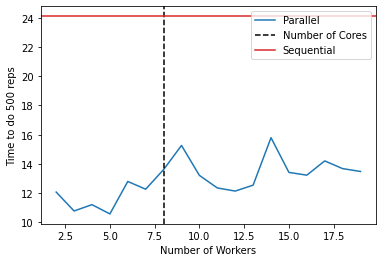

In [248]:
import matplotlib.pyplot as plt
plt.plot(list(range(2,20)),l,label="Parallel")
plt.xlabel("Number of Workers")
plt.ylabel("Time to do 500 reps")
plt.axvline(8,color='black',ls='--',label="Number of Cores")
plt.axhline(24.10096502304077,color="C3",label="Sequential")
plt.legend()

Depending on the run, more workers does not always equal good performance. In general, always start with allocating 1 core to 1 worker.

For most problems, simply doing it in parallel is still a massive speed improvement.